# Objective

Evaluate the effect of adding helper images to the instructions in Quanti.us.

In [1]:
from sklearn.neighbors import KDTree
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import sys, os
from fishanno import QuantiusAnnotation, SpotAnnotationAnalysis, autocrop, clus, param, util, vis

%load_ext autoreload
%autoreload 2

## User Inputs

In [3]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 10
max_num_crops = 7
colors = ['cyan', 'blue', 'purple', 'violet', 'magenta', 'red', 'orange', 'yellow', 'green', ]    
crosshair_ratio = 0.04
max_num_crops = 4
max_crowded_ratio = 0.3
clustering_params = ['AffinityPropagation', -350]
declumping_params = ['KMeans', 2]

In [4]:
sample_img_filename = 'ISS_rnd0_ch0_z0.png'
sample_img_path = './sample_image_filtered/' + sample_img_filename
sample_coords_filename = 'ISS_rnd0_ch0_z0.csv'
sample_coords_path = './sample_image_filtered/' + sample_coords_filename

In [5]:
test_img_filename = 'ISS_rnd1_ch1_z0'
test_img_path = './test_images_filtered/images/%s.png' % test_img_filename
test_coords_path = './test_images_filtered/coords/%s.csv' % test_img_filename

# Part 4: QC and Reassembly

### This section of the pipeline:

- Inputs:
    - annotations from Quanti.us for each crop
- Outputs:
    - total consensus annotations for each image

Plot individual annotations for crops of ISS_rnd1_ch1_z0 

In [6]:
json_filenames = [
    'ISS_rnd1_ch1_z0_helper_1_no_circle_no_orig.json',
    'ISS_rnd1_ch1_z0_helper_1_no_circle_w_orig.json',
    'ISS_rnd1_ch1_z0_helper_1_w_circle_no_orig.json',
    'ISS_rnd1_ch1_z0_helper_1_w_circle_w_orig.json',
    'ISS_rnd1_ch1_z0_helper_2_no_circle_no_orig.json',
    'ISS_rnd1_ch1_z0_helper_2_no_circle_w_orig.json',
    'ISS_rnd1_ch1_z0_helper_2_w_circle_no_orig.json',
    'ISS_rnd1_ch1_z0_helper_2_w_circle_w_orig.json',
]

ISS_rnd1_ch1_z0_helper_1_no_circle_no_orig.json


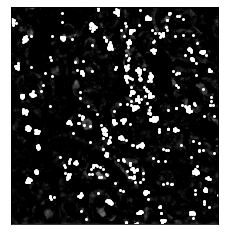

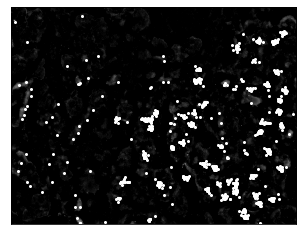

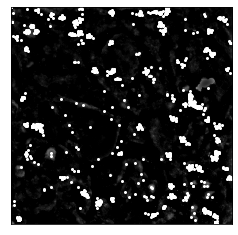

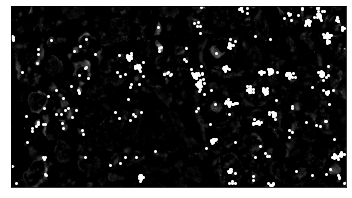

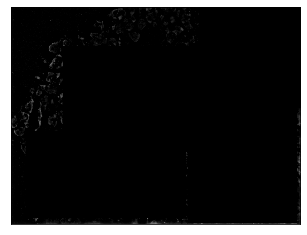

ISS_rnd1_ch1_z0_helper_1_no_circle_w_orig.json


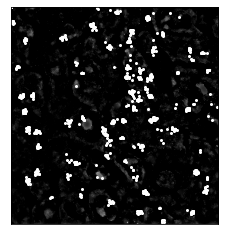

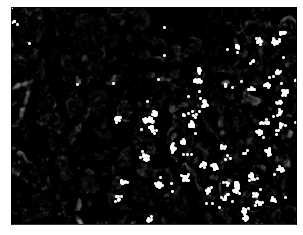

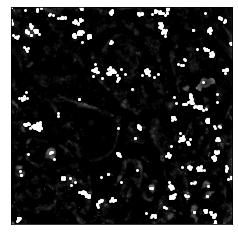

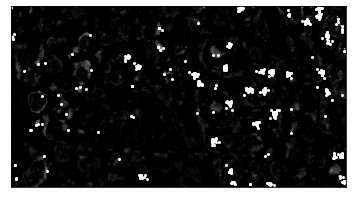

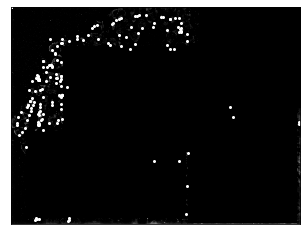

ISS_rnd1_ch1_z0_helper_1_w_circle_no_orig.json


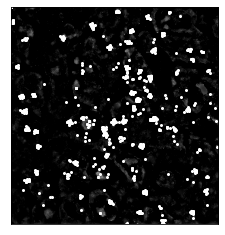

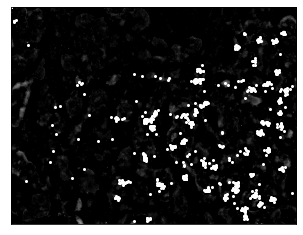

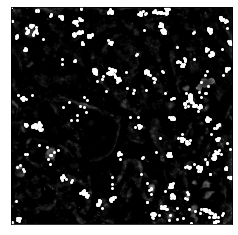

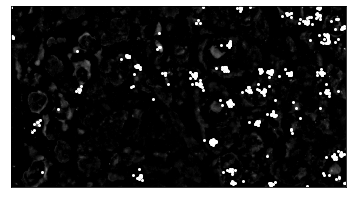

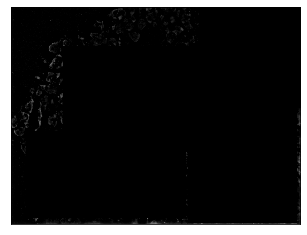

ISS_rnd1_ch1_z0_helper_1_w_circle_w_orig.json


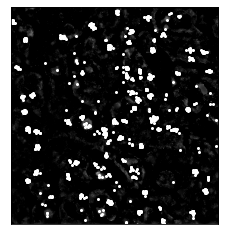

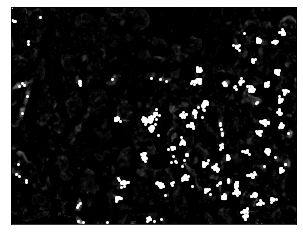

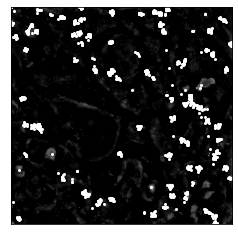

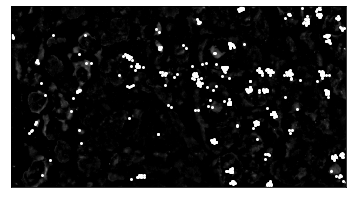

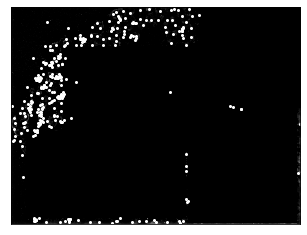

ISS_rnd1_ch1_z0_helper_2_no_circle_no_orig.json


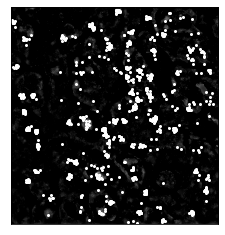

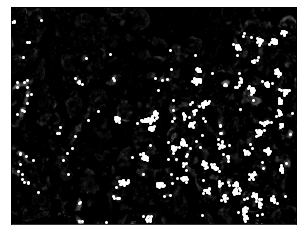

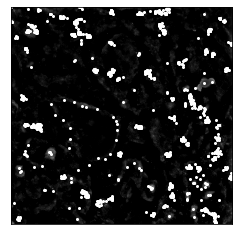

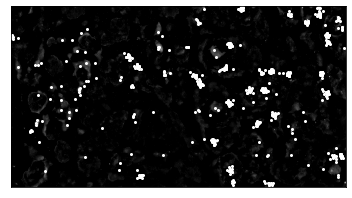

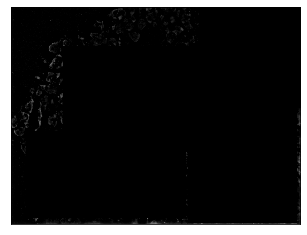

ISS_rnd1_ch1_z0_helper_2_no_circle_w_orig.json


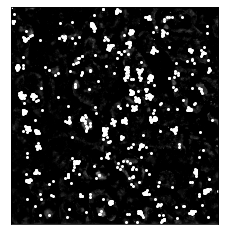

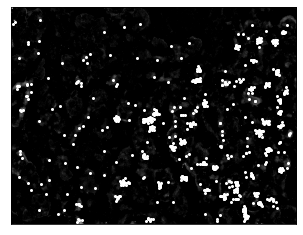

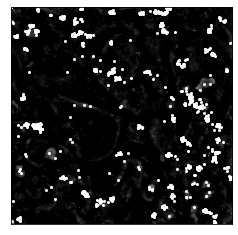

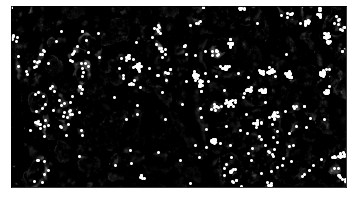

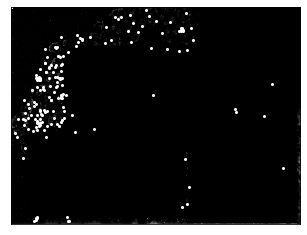

ISS_rnd1_ch1_z0_helper_2_w_circle_no_orig.json


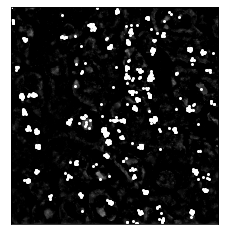

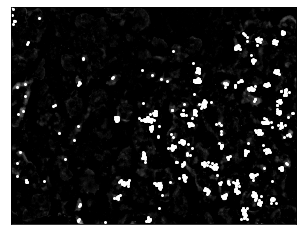

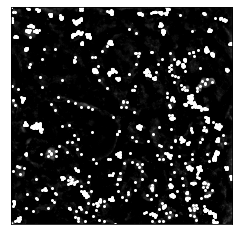

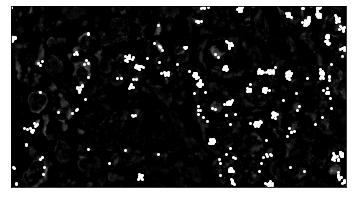

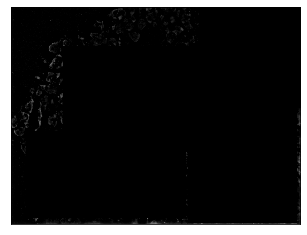

ISS_rnd1_ch1_z0_helper_2_w_circle_w_orig.json


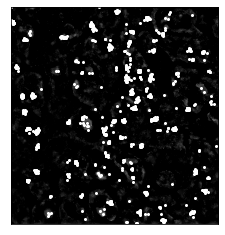

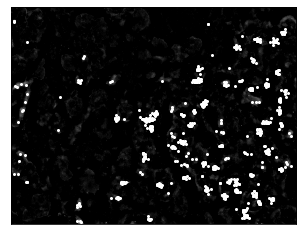

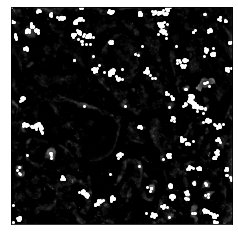

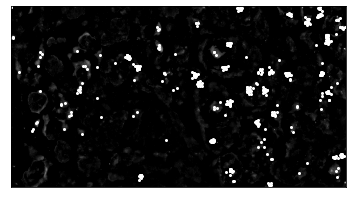

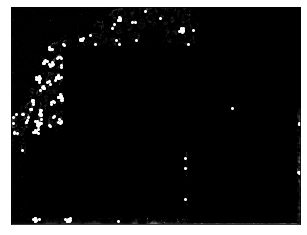

In [13]:
for json_filename in json_filenames:
    
    print(json_filename)
    
    crops_path = './crops/%s/' % test_img_filename
    consensus_path = './consensus/%s/' % test_img_filename
    json_filepath = './anno/%s' % json_filename
    crop_names = ['%s_%s.png' % (test_img_filename, ind) for ind in range(4)]
    crop_names.append('%s_blacked.png' % test_img_filename)

    for crop_name in crop_names:
        plt.figure()
        qa = QuantiusAnnotation(json_filepath, crop_name)
        sa = SpotAnnotationAnalysis(qa)
        anno_all = qa.df()
        x_vals = list(anno_all['x'])
        im = imread(crops_path + crop_name, as_gray=True)
        img_height = len(im)
        y_vals = [img_height - y for y in list(anno_all['y'])]
        plt.scatter(x_vals, y_vals, color='white', s=4)
        plt.imshow(im, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

### QC, save consensus coords

In [34]:
if not os.path.exists('./consensus/'):
    os.mkdir('consensus')

In [14]:
json_filenames[0]

'ISS_rnd1_ch1_z0_helper_1_no_circle_no_orig.json'

In [20]:
crops_path = './crops/%s/' % test_img_filename
img_filenames = [f for f in os.listdir(crops_path) if f.endswith('.png')]

for json_filename in json_filenames:
    
    print(json_filename)
    
    crops_path = './crops/%s/' % test_img_filename
    consensus_path = './consensus/%s/' % test_img_filename
    json_filepath = './anno/%s' % json_filename
    crop_names = ['%s_%s.png' % (test_img_filename, ind) for ind in range(4)]
    crop_names.append('%s_blacked.png' % test_img_filename)

    for img_filename in img_filenames:
        print('Now processing %s' % (img_filename))
        img_filepath = './crops/%s/%s' % (test_img_filename, img_filename)

        qa = QuantiusAnnotation(json_filepath, img_filename)
        sa = SpotAnnotationAnalysis(qa)
        anno_all = qa.df()
        if anno_all.empty:
            continue

        # cluster annotations
        clusters = sa.get_clusters(anno_all, clustering_params)  

        # apply QC
        cluster_size_threshold = clus.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = clus.sort_clusters_by_size(clusters, cluster_size_threshold)

        clumpiness_threshold = clus.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = clus.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        clusters_post_qc = nonclumpy_clusters

        if len(clumpy_clusters.index) is not 0:
            for i in range(len(clumpy_clusters.index)):
                subclusters = clus.declump(clumpy_clusters, i, declumping_params)
            clusters_post_qc = pd.concat([subclusters, clusters_post_qc], ignore_index=True)

        # save consensus coords        
        im = imread(img_filepath)
        img_height = len(im)
        clusters_post_qc_list = []
        for index in clusters_post_qc.index:
            row = clusters_post_qc.iloc[index]
            x, y = row['centroid_x'], row['centroid_y']
            clusters_post_qc_list.append([x, img_height-y])
        path = ('./consensus/helpers/%s_%s' % (json_filename, img_filename)).replace('png', 'csv')
        np.savetxt(path, np.asarray(clusters_post_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')


ISS_rnd1_ch1_z0_helper_1_no_circle_no_orig.json
Now processing ISS_rnd1_ch1_z0_blacked.png
Now processing ISS_rnd1_ch1_z0_2.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_3.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_1.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_0.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


ISS_rnd1_ch1_z0_helper_1_no_circle_w_orig.json
Now processing ISS_rnd1_ch1_z0_blacked.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_2.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_3.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_1.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_0.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


ISS_rnd1_ch1_z0_helper_1_w_circle_no_orig.json
Now processing ISS_rnd1_ch1_z0_blacked.png
Now processing ISS_rnd1_ch1_z0_2.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_3.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_1.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_0.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


ISS_rnd1_ch1_z0_helper_1_w_circle_w_orig.json
Now processing ISS_rnd1_ch1_z0_blacked.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_2.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_3.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_1.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_0.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


ISS_rnd1_ch1_z0_helper_2_no_circle_no_orig.json
Now processing ISS_rnd1_ch1_z0_blacked.png
Now processing ISS_rnd1_ch1_z0_2.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_3.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_1.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_0.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


ISS_rnd1_ch1_z0_helper_2_no_circle_w_orig.json
Now processing ISS_rnd1_ch1_z0_blacked.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_2.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_3.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_1.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_0.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


ISS_rnd1_ch1_z0_helper_2_w_circle_no_orig.json
Now processing ISS_rnd1_ch1_z0_blacked.png
Now processing ISS_rnd1_ch1_z0_2.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_3.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_1.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_0.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


ISS_rnd1_ch1_z0_helper_2_w_circle_w_orig.json
Now processing ISS_rnd1_ch1_z0_blacked.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_2.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_3.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_1.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing ISS_rnd1_ch1_z0_0.png


../../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


## Reassembly of consensus coords, save reassembled coords

ISS_rnd1_ch1_z0_helper_1_no_circle_no_orig.json


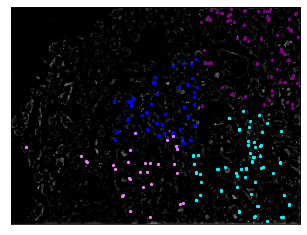

ISS_rnd1_ch1_z0_helper_1_no_circle_w_orig.json


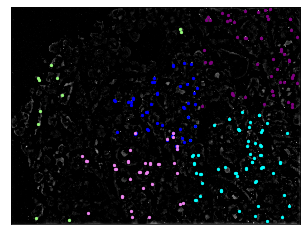

ISS_rnd1_ch1_z0_helper_1_w_circle_no_orig.json


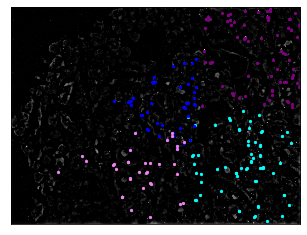

ISS_rnd1_ch1_z0_helper_1_w_circle_w_orig.json


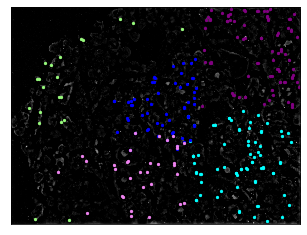

ISS_rnd1_ch1_z0_helper_2_no_circle_no_orig.json


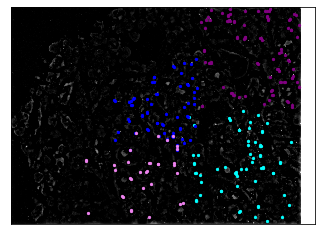

ISS_rnd1_ch1_z0_helper_2_no_circle_w_orig.json


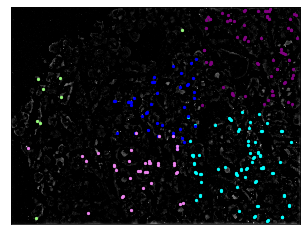

ISS_rnd1_ch1_z0_helper_2_w_circle_no_orig.json


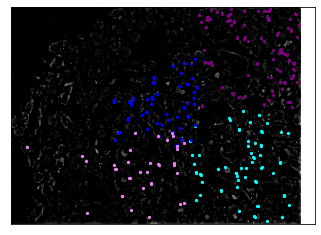

ISS_rnd1_ch1_z0_helper_2_w_circle_w_orig.json


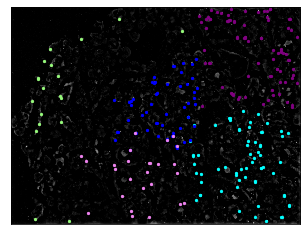

In [32]:
test_img_path = './test_images_filtered/images/%s.png' % test_img_filename

for json_filename in json_filenames:
    
    print(json_filename)
    
    total = []
    
    im = imread(test_img_path, as_gray=True)
    plt.imshow(im, cmap='gray')
    
    blacked_path = './consensus/helpers/%s_%s_blacked.csv' % (json_filename, test_img_filename)
    if os.path.exists(blacked_path):
        coords_blacked = np.asarray(pd.read_csv(blacked_path))
        for coord in coords_blacked:
            plt.scatter(coord[0], coord[1], color='xkcd:light green', s=5)
            total.append([coord[0], coord[1]])

    for i in range(4):
        coords_path = './consensus/helpers/%s_%s_%s.csv' % (json_filename, test_img_filename, str(i))
        coords = np.asarray(pd.read_csv(coords_path))
        stats_path = './crops/' + test_img_filename + '/' + test_img_filename + '_' + str(i) + '.csv'
        stats = np.asarray(pd.read_csv(stats_path, header = None))
        xmin = stats[0][0]
        ymin = stats[2][0]
        ymax = stats[3][0]
        height = ymax - ymin
        zoom_factor = stats[4][0]

        refit = []
        for coord in coords:
            x = coord[0]/zoom_factor + xmin
            y = coord[1]/zoom_factor + ymin
            refit.append([x, y])
            total.append([x, y])
        refit = np.asarray(refit)

        for coord in refit:
            plt.scatter(coord[0], coord[1], color=colors[i], s=5)

    plt.xticks([])
    plt.yticks([])
    plt.savefig('./consensus/helpers/%s_reassembled.pdf' % json_filename.replace('.json', ''), transparent=True, bbox_inches="tight")
    path = './consensus/helpers/%s.csv' % json_filename.replace('.json', '_total')
    np.savetxt(path, np.asarray(total), delimiter=",", comments='', header='centroid_x,centroid_y')
    plt.show()
    

ISS_rnd1_ch1_z0_helper_1_no_circle_no_orig.json


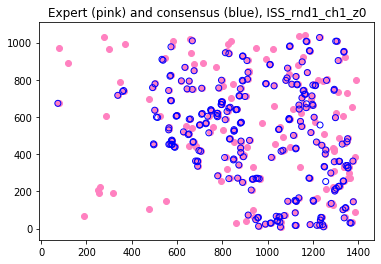

ISS_rnd1_ch1_z0_helper_1_no_circle_w_orig.json


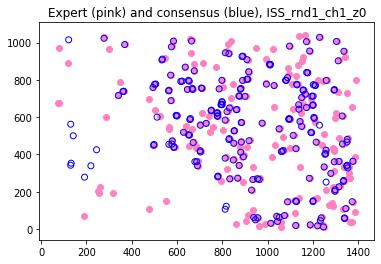

ISS_rnd1_ch1_z0_helper_1_w_circle_no_orig.json


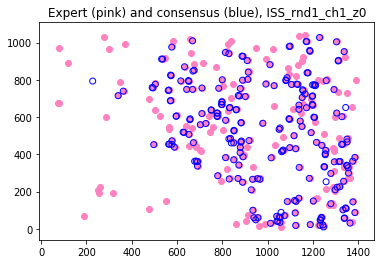

ISS_rnd1_ch1_z0_helper_1_w_circle_w_orig.json


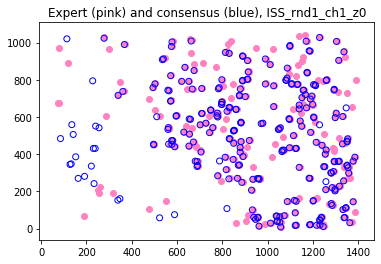

ISS_rnd1_ch1_z0_helper_2_no_circle_no_orig.json


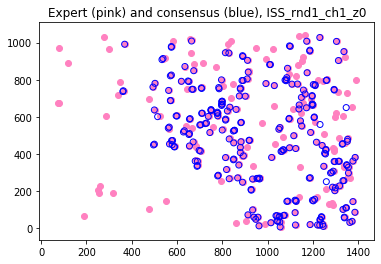

ISS_rnd1_ch1_z0_helper_2_no_circle_w_orig.json


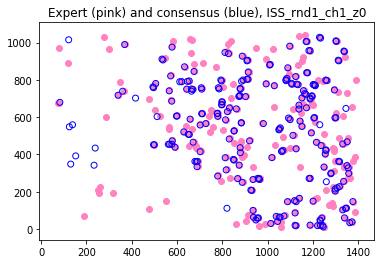

ISS_rnd1_ch1_z0_helper_2_w_circle_no_orig.json


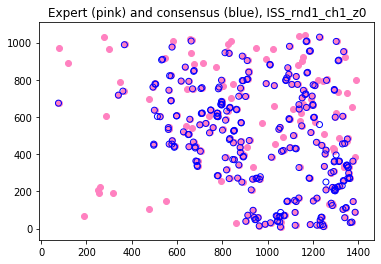

ISS_rnd1_ch1_z0_helper_2_w_circle_w_orig.json


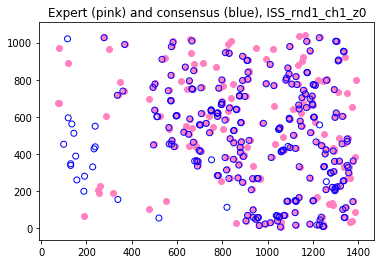

In [34]:
reference_filepath = './test_images_filtered/coords/%s.csv' % test_img_filename
reference_coords = np.asarray(pd.read_csv(reference_filepath))

for json_filename in json_filenames:
    
    print(json_filename)
    
    consensus_total_path = './consensus/helpers/%s.csv' % json_filename.replace('.json', '_total')
    consensus_coords = np.asarray(pd.read_csv(consensus_total_path))

    plt.figure()
    for x, y in reference_coords:
        plt.scatter([x], [y], c='xkcd:pink')
    
    for x, y in consensus_coords:
        plt.scatter([x], [y], edgecolor='blue', facecolor='None')
        
    plt.title('Expert (pink) and consensus (blue), %s' % test_img_filename)    
    plt.show()


# Part 5: Evaluation 

## Consensus vs. Reference

-----------------

ISS_rnd1_ch1_z0_helper_1_no_circle_no_orig.json

-----------------


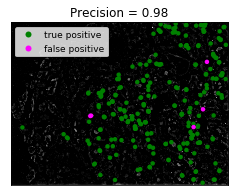

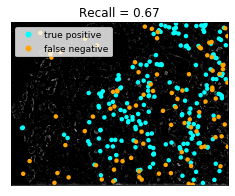

-----------------

ISS_rnd1_ch1_z0_helper_1_no_circle_w_orig.json

-----------------


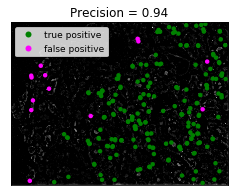

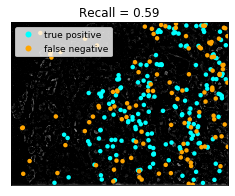

-----------------

ISS_rnd1_ch1_z0_helper_1_w_circle_no_orig.json

-----------------


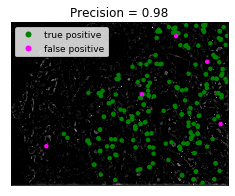

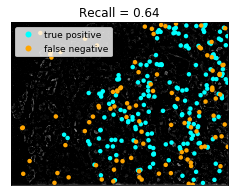

-----------------

ISS_rnd1_ch1_z0_helper_1_w_circle_w_orig.json

-----------------


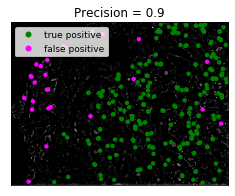

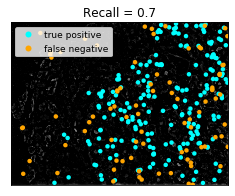

-----------------

ISS_rnd1_ch1_z0_helper_2_no_circle_no_orig.json

-----------------


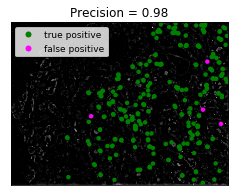

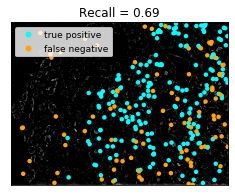

-----------------

ISS_rnd1_ch1_z0_helper_2_no_circle_w_orig.json

-----------------


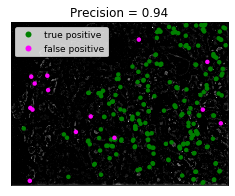

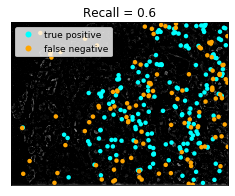

-----------------

ISS_rnd1_ch1_z0_helper_2_w_circle_no_orig.json

-----------------


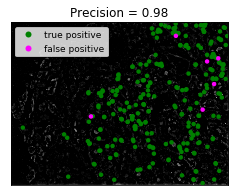

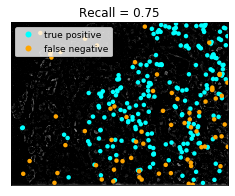

-----------------

ISS_rnd1_ch1_z0_helper_2_w_circle_w_orig.json

-----------------


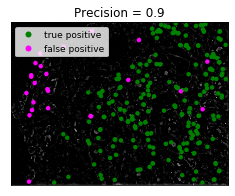

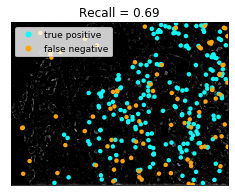

In [7]:
data = []

test_img_filepath = './test_images_filtered/images/%s.png' % test_img_filename
im = imread(test_img_filepath)
img_height = len(im)

reference_filepath = './test_images_filtered/coords/%s.csv' % test_img_filename
reference_coords = np.asarray(pd.read_csv(reference_filepath))
reference_kdt = KDTree(reference_coords, leaf_size=2, metric='euclidean')

for json_filename in json_filenames:
    
    print('-----------------\n\n%s\n\n-----------------' % json_filename)
    
    consensus_total_path = './consensus/helpers/%s.csv' % json_filename.replace('.json', '_total')
    consensus_coords = np.asarray(pd.read_csv(consensus_total_path))
    consensus_kdt = KDTree(consensus_coords, leaf_size=2, metric='euclidean')
    
    correct_consensus = []
    incorrect_consensus = []
    detected_reference = []
    undetected_reference = []

    # correct vs. incorrect

    for consensus_coord in consensus_coords:
        dist, ind = reference_kdt.query([consensus_coord], k=1)
        if dist[0][0] < correctness_threshold:
            correct_consensus.append(consensus_coord)
        else:
            incorrect_consensus.append(consensus_coord)

    # detected vs. undetected

    for reference_coord in reference_coords:
        dist, ind = consensus_kdt.query([reference_coord], k=1)
        if dist[0][0] < correctness_threshold:
            detected_reference.append(reference_coord)
        else:
            undetected_reference.append(reference_coord)
    
    precision = len(correct_consensus)/len(consensus_coords)
    recall = len(detected_reference)/len(reference_coords)
    
    markersize = 20
    
    # plot Precision
    plt.figure(figsize=(5,3))
    for x, y in correct_consensus:
        plt.scatter(x, y, edgecolors='None', facecolors='green', s=markersize)
    for x, y in incorrect_consensus:
        plt.scatter(x, y, edgecolors='None', facecolors='magenta', s=markersize)
        
    handle1 = Line2D([0],[0], marker='o', color='None', markerfacecolor='green', markeredgecolor='None', label='true positive')
    handle2 = Line2D([0],[0], marker='o', color='None', markerfacecolor='magenta', markeredgecolor='None', label='false positive')
    legend = plt.legend(handles=[handle1, handle2], loc='upper left', frameon=1, prop={'size': 9})
    frame = legend.get_frame()
    frame.set_facecolor('white')
        
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    title = 'Precision = %s' % round(precision, 2)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('./consensus/helpers/%s_precision.pdf' % json_filename.replace('.json', ''), transparent=True, bbox_inches="tight")
    plt.show()
    
    # plot Recall
    plt.figure(figsize=(5,3))
    for x, y in detected_reference:
        plt.scatter(x, y, edgecolors='None', facecolors='cyan', s=markersize)
    for x, y in undetected_reference:
        plt.scatter(x, y, edgecolors='None', facecolors='orange', s=markersize)
        
    handle1 = Line2D([0],[0], marker='o', color='None', markerfacecolor='cyan', markeredgecolor='None', label='true positive')
    handle2 = Line2D([0],[0], marker='o', color='None', markerfacecolor='orange', markeredgecolor='None', label='false negative')
    legend = plt.legend(handles=[handle1, handle2], loc='upper left', frameon=1, prop={'size': 9})
    frame = legend.get_frame()
    frame.set_facecolor('white')
    
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    title = 'Recall = %s' % round(recall, 2)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('./consensus/helpers/%s_recall.pdf' % json_filename.replace('.json', ''), transparent=True, bbox_inches="tight")
    plt.show()
    
    data.append([json_filename.replace('.json', ''), precision, recall])

In [8]:
original_precision = 0.81
original_recall = 0.76

In [145]:
np.mean(precision_with_parent + precision_without_parent) - original_precision

0.14107101647371934

In [146]:
original_recall - np.mean(recall_with_parent + recall_without_parent)

0.09275261324041806

In [148]:
precision_circle = [0.9776785714285714, 0.9044117647058824, 0.9775280898876404, 0.904]
precision_no_circle = [0.9803149606299213, 0.9395348837209302, 0.9846743295019157, 0.9775280898876404]

In [149]:
np.mean(precision_circle)

0.9409046065055235

In [150]:
np.mean(precision_no_circle)

0.9705130659351019

In [152]:
recall_no_circle = [0.6724738675958188, 0.5888501742160279, 0.686411149825784, 0.6027874564459931]
recall_circle = [0.6411149825783972, 0.7038327526132404, 0.7491289198606271, 0.6933797909407665]

In [153]:
np.mean(recall_no_circle)

0.637630662020906

In [154]:
np.mean(recall_circle)

0.6968641114982578

In [157]:
helper_1_precision = [0.9803149606299213, 0.9395348837209302, 0.9776785714285714, 0.9044117647058824]
helper_2_precision = [0.9846743295019157, 0.9404255319148936, 0.9775280898876404, 0.904]
np.mean(helper_2_precision) - np.mean(helper_1_precision)

0.0011719427047861553

In [159]:
helper_1_recall = [0.6724738675958188, 0.5888501742160279, 0.6411149825783972, 0.7038327526132404]
helper_2_recall = [0.686411149825784, 0.6027874564459931, 0.7491289198606271, 0.6933797909407665]
np.mean(helper_1_recall) - np.mean(helper_2_recall)

-0.03135888501742157

In [163]:
w_orig_precision = [0.9395348837209302, 0.9044117647058824, 0.9404255319148936, 0.904]
no_orig_precision = [0.9803149606299213, 0.9776785714285714, 0.9846743295019157, 0.9775280898876404]
np.mean(no_orig_precision) - np.mean(w_orig_precision)

0.05795594277658567

In [164]:
w_orig_recall = [0.5888501742160279, 0.7038327526132404, 0.6027874564459931, 0.6933797909407665]
no_orig_recall = [0.6724738675958188, 0.6411149825783972, 0.686411149825784, 0.7491289198606271]
np.mean(no_orig_recall) - np.mean(w_orig_recall)

0.04006968641114983

In [158]:
data

[['ISS_rnd1_ch1_z0_helper_1_no_circle_no_orig',
  0.9803149606299213,
  0.6724738675958188],
 ['ISS_rnd1_ch1_z0_helper_1_no_circle_w_orig',
  0.9395348837209302,
  0.5888501742160279],
 ['ISS_rnd1_ch1_z0_helper_1_w_circle_no_orig',
  0.9776785714285714,
  0.6411149825783972],
 ['ISS_rnd1_ch1_z0_helper_1_w_circle_w_orig',
  0.9044117647058824,
  0.7038327526132404],
 ['ISS_rnd1_ch1_z0_helper_2_no_circle_no_orig',
  0.9846743295019157,
  0.686411149825784],
 ['ISS_rnd1_ch1_z0_helper_2_no_circle_w_orig',
  0.9404255319148936,
  0.6027874564459931],
 ['ISS_rnd1_ch1_z0_helper_2_w_circle_no_orig',
  0.9775280898876404,
  0.7491289198606271],
 ['ISS_rnd1_ch1_z0_helper_2_w_circle_w_orig', 0.904, 0.6933797909407665]]

In [83]:
deltas = []
for name, precision, recall in data:
    deltas.append([name, precision-original_precision, recall-original_recall])

In [10]:
precision_with_parent = [data[1][1], data[3][1], data[5][1], data[7][1]]
precision_without_parent = [data[0][1], data[2][1], data[4][1], data[6][1]]

recall_with_parent = [data[1][2], data[3][2], data[5][2], data[7][2]]
recall_without_parent = [data[0][2], data[2][2], data[4][2], data[6][2]]

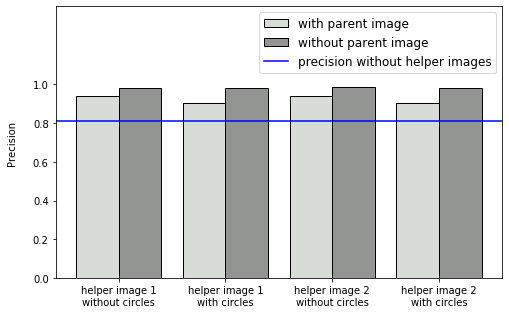

In [139]:
ind = np.arange(4)
width = 0.4
plt.figure(figsize=(8,5))
plt.bar(ind, precision_with_parent, width, label='with parent image', color='xkcd:light gray', edgecolor='black')
plt.bar(ind + width, precision_without_parent, width, label='without parent image', color='xkcd:gray', edgecolor='black')
plt.axhline(y=original_precision, color='b')

plt.ylim(0, 1.4)
plt.xticks(ind + width/2, ['helper image 1\nwithout circles', 'helper image 1\nwith circles', 'helper image 2\nwithout circles', 'helper image 2\nwith circles'])
plt.ylabel('Precision\n')
plt.yticks(np.arange(0, 1.1, 0.2))

light_patch = mpatches.Patch(facecolor='xkcd:light gray', edgecolor='black', label='with parent image')
dark_patch = mpatches.Patch(facecolor='xkcd:gray', edgecolor='black', label='without parent image')
kmeans_line = Line2D([0],[0], color='b', label='precision without helper images')
plt.legend(handles=[light_patch, dark_patch, kmeans_line], prop={'size': 12}, loc='upper right')

plt.savefig('./helpers/precision.pdf', transparent=True, bbox_inches="tight")
plt.show()

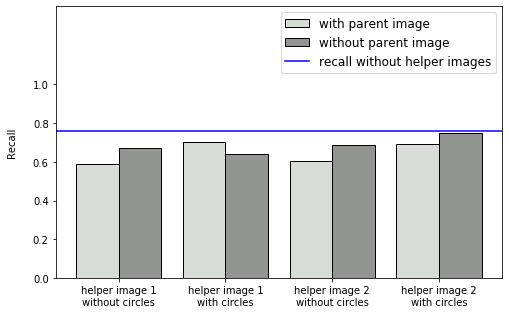

In [11]:
ind = np.arange(4)
width = 0.4
plt.figure(figsize=(8,5))
plt.bar(ind, recall_with_parent, width, label='with parent image', color='xkcd:light gray', edgecolor='black')
plt.bar(ind + width, recall_without_parent, width, label='without parent image', color='xkcd:gray', edgecolor='black')
plt.axhline(y=original_recall, color='b')

plt.ylim(0, 1.4)
plt.xticks(ind + width/2, ['helper image 1\nwithout circles', 'helper image 1\nwith circles', 'helper image 2\nwithout circles', 'helper image 2\nwith circles'])
plt.ylabel('Recall\n')
plt.yticks(np.arange(0, 1.1, 0.2))

light_patch = mpatches.Patch(facecolor='xkcd:light gray', edgecolor='black', label='with parent image')
dark_patch = mpatches.Patch(facecolor='xkcd:gray', edgecolor='black', label='without parent image')
kmeans_line = Line2D([0],[0], color='b', label='recall without helper images')
plt.legend(handles=[light_patch, dark_patch, kmeans_line], prop={'size': 12}, loc='upper right')

plt.savefig('./helpers/recall.pdf', transparent=True, bbox_inches="tight")
plt.show()

In [84]:
delta_precision_with_parent = [deltas[1][1], deltas[3][1], deltas[5][1], deltas[7][1]]
delta_precision_without_parent = [deltas[0][1], deltas[2][1], deltas[4][1], deltas[6][1]]

delta_recall_with_parent = [deltas[1][2], deltas[3][2], deltas[5][2], deltas[7][2]]
delta_recall_without_parent = [deltas[0][2], deltas[2][2], deltas[4][2], deltas[6][2]]

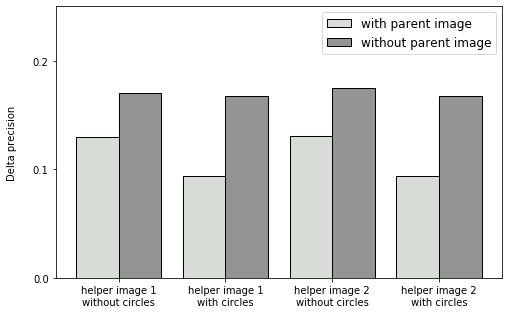

In [137]:
ind = np.arange(4)
width = 0.4
plt.figure(figsize=(8,5))
plt.bar(ind, delta_precision_with_parent, width, label='with parent image', color='xkcd:light gray', edgecolor='black')
plt.bar(ind + width, delta_precision_without_parent, width, label='without parent image', color='xkcd:gray', edgecolor='black')

plt.ylim(0, 0.25)
plt.xticks(ind + width/2, ['helper image 1\nwithout circles', 'helper image 1\nwith circles', 'helper image 2\nwithout circles', 'helper image 2\nwith circles'])
plt.ylabel('Delta precision\n')
plt.yticks(np.arange(0, 0.3, 0.1))
plt.legend(loc='upper right', prop={'size': 12})
plt.savefig('./helpers/precision_deltas.pdf', transparent=True, bbox_inches="tight")
plt.show()

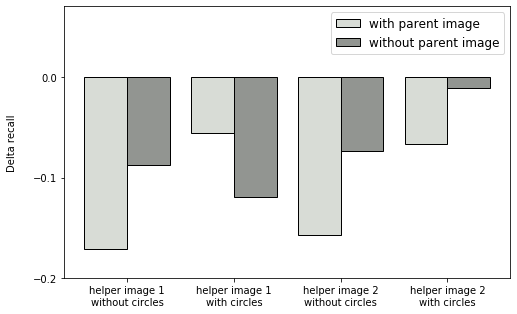

In [136]:
ind = np.arange(4)
width = 0.4
plt.figure(figsize=(8,5))
plt.bar(ind, delta_recall_with_parent, width, label='with parent image', color='xkcd:light gray', edgecolor='black')
plt.bar(ind + width, delta_recall_without_parent, width, label='without parent image', color='xkcd:gray', edgecolor='black')

plt.ylim(-0.2, 0.07)
plt.xticks(ind + width/2, ['helper image 1\nwithout circles', 'helper image 1\nwith circles', 'helper image 2\nwithout circles', 'helper image 2\nwith circles'])
plt.ylabel('Delta recall\n')
plt.yticks(np.arange(-0.2, 0.01, 0.1))
plt.legend(loc='upper right', prop={'size': 12})
plt.savefig('./helpers/recall_deltas.pdf', transparent=True, bbox_inches="tight")
plt.show()